# TP de filtrage bayésien

Calcul de l'intégrale $\displaystyle \int_{0}^{1} cos(\frac{\pi x}{2}) \, \mathrm{d}x$ par simulation de Monte Carlo

In [32]:
import numpy as np
import numpy.random
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad

Par MC brute

In [54]:
iterations_mc = 1000
taille_echantillon=50

def g(x):
    return(math.cos(math.pi*x/2))

def mu_n(taille_echantillon):
    """generation d'une réalisation de mu_n"""
    return(np.mean([g(np.random.uniform(0,1)) for i in range(taille_echantillon)]))

def simulation_mu_n(iterations_mc,taille_echantillon,estimateur):
    """return un array de taille iterations_mc réalisations de mu_n"""
    L=[]
    for i in range(iterations_mc):
        L.append(estimateur(taille_echantillon))
    return(np.array(L))


In [55]:
print("variance empirique : "+str(np.var(simulation_mu_n(iterations_mc,taille_echantillon,mu_n))))
print("variance théorique : " + str(((1/2-4/(math.pi)**2)/50)))

variance empirique : 0.002073941420789133
variance théorique : 0.001894305308612978


Par importance sampling

In [40]:
def developement_limite_g(x):
    return(1 - ((math.pi*x)**2)/8 )

def q_tilde(x):
    facteur_normalisation, err = quad(developement_limite_g,0,1)
    # print(facteur_normalisation)
    return(developement_limite_g(x)/facteur_normalisation)


Affichage de g et de son DL en 0

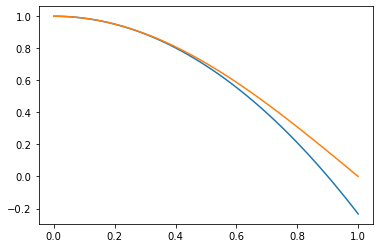

In [48]:
X = np.linspace(0,1,100)
DL= developement_limite_g(X)
G = [g(x) for x in X]
plt.plot(X,DL)
plt.plot(X,G)
plt.show()

Affichage de $\overset{\sim}{q}$ donne :


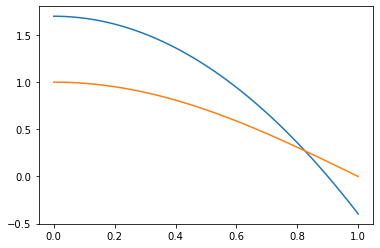

In [49]:
X = np.linspace(0,1,100)
Q= q_tilde(X)
G = [g(x) for x in X]
plt.plot(X,Q)
plt.plot(X,G)
plt.show()

In [75]:
def quotient_g_q(x):
    return(g(x)/q_tilde(x))

def mu_tilde_n(taille_echantillon):
    """generation d'une réalisation de mu_tilde_n"""
    return(np.mean([quotient_g_q(generation_q_tilde()) for i in range(taille_echantillon)]))

def generation_q_tilde(): ## calculer la propriété d'acceptation
    X = np.random.uniform(0,1,1)
    U = np.random.uniform(0,1,1)
    C= q_tilde(0)
    while q_tilde(X)<C*U : 
        X = np.random.uniform(0,1,1)
        U = np.random.uniform(0,1,1)
    return(X)
    

Calcul de la variance empirique de $\hat{\mu}_{N}$ estimé par importance sampling avec le changement de probabilité $\overset{\sim}{q}$ 

In [100]:
# print("variance empirique importance sampling : " + str(np.var(simulation_mu_n(iterations_mc,taille_echantillon,mu_tilde_n))))
# variance theorique
def integrande_var_theo(x):
    return(g(x)*g(x)/q_tilde(x))
    
res, err = quad(integrande_var_theo,0,1)
var_theorique = (res-4/((math.pi)**2))/taille_echantillon

<ipython-input-100-06a259dead77>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(integrande_var_theo,0,1)


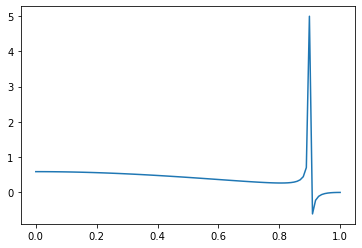

In [102]:
X = np.linspace(0,1,100)
Y = [integrande_var_theo(x) for x in X]
plt.plot(X,Y)